# Clustering Experimentation

This notebook takes you through the experiments we conducted with regards to segmentation abilities of the produced TGN embeddings. Make sure that you have all the requred packages and have correclty initialised your enviroment.

In [2]:
import torch
from model.tgn import TGN
from utils.utils import get_neighbor_finder
from utils.data_processing import get_data, compute_time_statistics
import numpy as np

Set your seeds for reproducability

Now we reload the previously trained model

Takes a while to run this cell so be prepared

In [3]:
torch.manual_seed(0)
np.random.seed(0)
DATA = "ae_large"
node_features, edge_features, full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data = get_data(DATA, different_new_nodes_between_val_and_test=False, randomize_features=False)

FileNotFoundError: Missing dataset files: ../data/processed/ae_large.csv, ../data/processed/ae_large.npy, ../data/processed/ae_large_node.npy

In [3]:
# === 1. Reconstruct the neighbor finder ===
train_ngh_finder = get_neighbor_finder(train_data, uniform=False)

# === 2. Compute time statistics ===
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = compute_time_statistics(
    full_data.sources, full_data.destinations, full_data.timestamps
)

# === 3. Select device ===
device_string = f"cuda:{0}" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

# === 4. Re-instantiate TGN using new hyperparameters ===
tgn = TGN(
    neighbor_finder=train_ngh_finder,
    node_features=node_features,
    edge_features=edge_features,
    device=device,
    n_layers=1,
    n_heads=1,
    dropout=0.0,
    use_memory=True,
    message_dimension=8,
    memory_dimension=8,
    memory_update_at_start=True,  # memory_update_at_end=False → start=True
    embedding_module_type="graph_attention",
    message_function="identity",
    aggregator_type="last",
    memory_updater_type="gru",
    n_neighbors=1,
    mean_time_shift_src=mean_time_shift_src,
    std_time_shift_src=std_time_shift_src,
    mean_time_shift_dst=mean_time_shift_dst,
    std_time_shift_dst=std_time_shift_dst,
    use_destination_embedding_in_message=False,
    use_source_embedding_in_message=False,
    dyrep=False
)

# === 5. Load model state ===
checkpoint_path = "./saved_models/attn_2_le_mem-0.pth"  # adjust if filename differs
state_dict = torch.load(checkpoint_path, map_location=device)
tgn.load_state_dict(state_dict)

# === Optional: restore memory if stored separately ===
if hasattr(tgn, "memory") and "memory" in state_dict:
    tgn.memory.restore(state_dict["memory"])

# === 6. Set to evaluation mode ===
tgn.eval()
print("✅ TGN model successfully loaded and ready for inference (ae_large, 8D setup).")


mem_dim 8
raw_msg dim 176


RuntimeError: Error(s) in loading state_dict for TGN:
	Missing key(s) in state_dict: "memory_projector.weight", "memory_projector.bias", "embedding_module.memory_projector.weight", "embedding_module.memory_projector.bias". 
	Unexpected key(s) in state_dict: "embedding_module.node_proj.weight", "embedding_module.edge_proj.weight", "embedding_module.time_proj.weight". 
	size mismatch for time_encoder.w.weight: copying a param with shape torch.Size([8, 1]) from checkpoint, the shape in current model is torch.Size([158, 1]).
	size mismatch for time_encoder.w.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([158]).
	size mismatch for memory_updater.memory_updater.weight_ih: copying a param with shape torch.Size([24, 26]) from checkpoint, the shape in current model is torch.Size([24, 176]).
	size mismatch for embedding_module.time_encoder.w.weight: copying a param with shape torch.Size([8, 1]) from checkpoint, the shape in current model is torch.Size([158, 1]).
	size mismatch for embedding_module.time_encoder.w.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([158]).
	size mismatch for embedding_module.attention_models.0.merger.fc1.weight: copying a param with shape torch.Size([8, 24]) from checkpoint, the shape in current model is torch.Size([158, 474]).
	size mismatch for embedding_module.attention_models.0.merger.fc1.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([158]).
	size mismatch for embedding_module.attention_models.0.merger.fc2.weight: copying a param with shape torch.Size([8, 8]) from checkpoint, the shape in current model is torch.Size([158, 158]).
	size mismatch for embedding_module.attention_models.0.merger.fc2.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([158]).
	size mismatch for embedding_module.attention_models.0.multi_head_target.q_proj_weight: copying a param with shape torch.Size([16, 16]) from checkpoint, the shape in current model is torch.Size([316, 316]).
	size mismatch for embedding_module.attention_models.0.multi_head_target.k_proj_weight: copying a param with shape torch.Size([16, 24]) from checkpoint, the shape in current model is torch.Size([316, 318]).
	size mismatch for embedding_module.attention_models.0.multi_head_target.v_proj_weight: copying a param with shape torch.Size([16, 24]) from checkpoint, the shape in current model is torch.Size([316, 318]).
	size mismatch for embedding_module.attention_models.0.multi_head_target.in_proj_bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([948]).
	size mismatch for embedding_module.attention_models.0.multi_head_target.out_proj.weight: copying a param with shape torch.Size([16, 16]) from checkpoint, the shape in current model is torch.Size([316, 316]).
	size mismatch for embedding_module.attention_models.0.multi_head_target.out_proj.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([316]).
	size mismatch for affinity_score.fc1.weight: copying a param with shape torch.Size([8, 16]) from checkpoint, the shape in current model is torch.Size([158, 316]).
	size mismatch for affinity_score.fc1.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([158]).
	size mismatch for affinity_score.fc2.weight: copying a param with shape torch.Size([1, 8]) from checkpoint, the shape in current model is torch.Size([1, 158]).

Now we generate the node embeddings at the end of training time

In [117]:
max_train_time = train_data.timestamps.max()
all_nodes = np.array(sorted(np.unique(train_data.sources)))

dest_nodes = all_nodes.copy()
neg_nodes = all_nodes.copy()
dummy_edge_idxs = np.zeros_like(all_nodes, dtype=np.int32)
times = np.full_like(all_nb
with torch.no_grad():
    src_emb, _, _ = tgn.compute_temporal_embeddings(
        source_nodes=all_nodes,
        destination_nodes=dest_nodes,
        negative_nodes=neg_nodes,
        edge_times=times,
        edge_idxs=dummy_edge_idxs,
        n_neighbors=10
    )

Now we perform the clustering experiments, We first start off with the GMMs

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

std_embeddings = StandardScaler().fit_transform(src_emb)

pca = PCA(n_components=min(100, std_embeddings.shape[1]))
pca.fit(std_embeddings)

explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.6, label='Individual component variance')
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', color='red', label='Cumulative variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA – Explained Variance by Component')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
X = 10
pca = PCA(n_components=X)
std_embeddings = pca.fit_transform(std_embeddings)

In [122]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt



n_components_range = range(2, 20)
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(std_embeddings)
    aic = gmm.aic(std_embeddings)
    aic_scores.append(aic)
    print(f'n_components = {n}, AIC = {aic}')

best_n = n_components_range[np.argmin(aic_scores)]
print(f'\nBest number of clusters: {best_n}')

best_gmm = GaussianMixture(n_components=best_n, covariance_type='full', random_state=42)
best_gmm.fit(std_embeddings)
labels = best_gmm.predict(std_embeddings)

n_components = 2, AIC = 138816.169951435
n_components = 3, AIC = 138070.64953686038
n_components = 4, AIC = 78678.06787185757
n_components = 5, AIC = -30413.07601309975
n_components = 6, AIC = -104003.41556585673
n_components = 7, AIC = -76121.92534061143
n_components = 8, AIC = -204597.93185614236
n_components = 9, AIC = -273125.0732051988
n_components = 10, AIC = -247204.86845863186
n_components = 11, AIC = -283310.3539513805
n_components = 12, AIC = -297768.02607027313
n_components = 13, AIC = -323147.73476131214
n_components = 14, AIC = -337425.0447402623
n_components = 15, AIC = -364586.1542133244
n_components = 16, AIC = -329992.7144536824
n_components = 17, AIC = -327641.8491280003
n_components = 18, AIC = -321978.82845719776
n_components = 19, AIC = -326041.4126625038

Best number of clusters: 15


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(std_embeddings, labels)
db_score = davies_bouldin_score(std_embeddings, labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies–Bouldin Index: {db_score:.4f}")

In [123]:
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} instances")

Class 0: 12 instances
Class 1: 73 instances
Class 2: 13 instances
Class 3: 24 instances
Class 4: 55 instances
Class 5: 53 instances
Class 6: 56 instances
Class 7: 35 instances
Class 8: 51 instances
Class 9: 22 instances
Class 10: 47 instances
Class 11: 62 instances
Class 12: 83 instances
Class 13: 30 instances
Class 14: 42 instances


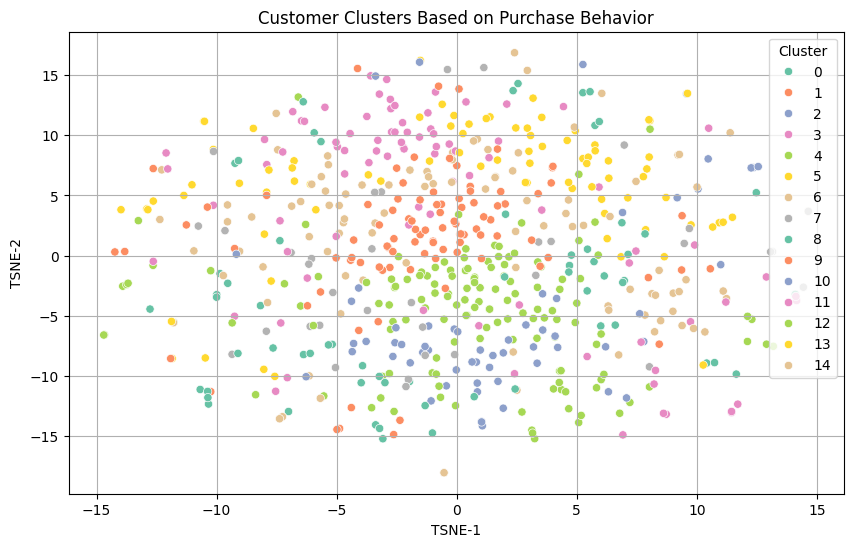

In [126]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42)
tsne_coords = tsne.fit_transform(std_embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_coords[:, 0], y=tsne_coords[:, 1], hue=labels, palette='Set2')
plt.title('Customer Clusters Based on Purchase Behavior')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

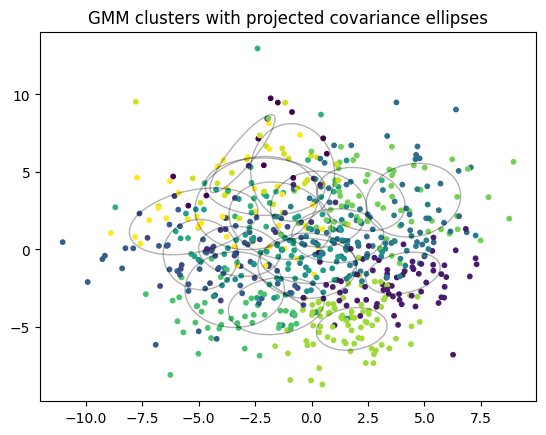

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

def project_mean_and_covar(mean, cov, P):
    mean_2d = P.T @ mean
    cov_2d = P.T @ cov @ P
    return mean_2d, cov_2d

def plot_gmm_ellipses_2d(gmm, ax, P, scale=1.0, alpha=0.3, color='black'):
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        cov = gmm.covariances_[i]
        
        mean_2d, cov_2d = project_mean_and_covar(mean, cov, P)
        
        vals, vecs = np.linalg.eigh(cov_2d)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]

        width, height = 2 * scale * np.sqrt(vals)
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        ellip = Ellipse(xy=mean_2d, width=width, height=height, angle=angle,
                        edgecolor=color, facecolor='none', alpha=alpha)
        ax.add_patch(ellip)

P = pca.components_.T  
fig, ax = plt.subplots()
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
plot_gmm_ellipses_2d(gmm, ax, P)
plt.title("GMM clusters with projected covariance ellipses")
plt.show()

Next we test the abbillity of k-means to cluster

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt

n_clusters_range = range(2, 20)
sil_scores, inertias = [], []

for k in n_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(std_embeddings)
    sil = silhouette_score(std_embeddings, labels)
    sil_scores.append(sil)
    inertias.append(kmeans.inertia_)
    print(f'k = {k}, Silhouette = {sil:.4f}, Inertia = {kmeans.inertia_:.2f}')

best_k = n_clusters_range[np.argmax(sil_scores)]
print(f'\nBest number of clusters (by Silhouette): {best_k}')

best_kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = best_kmeans.fit_predict(std_embeddings)

sil_score_val = silhouette_score(std_embeddings, labels)
db_score_val = davies_bouldin_score(std_embeddings, labels)

print(f"Silhouette Score: {sil_score_val:.4f}")
print(f"Davies–Bouldin Index: {db_score_val:.4f}")

Our analysis has conclude that GMMs would be the most benificial method to model these customers. Read report as to reasonionig

Next we want to perform some analyics on these clusterings and link them back to attributes in the original feature space and see if we can obseerve some noticeable seperation

We select the 2 most distinct clusters with enough members to prove statisticaly significant

In [124]:
best_gmm.means_.shape

(15, 164)

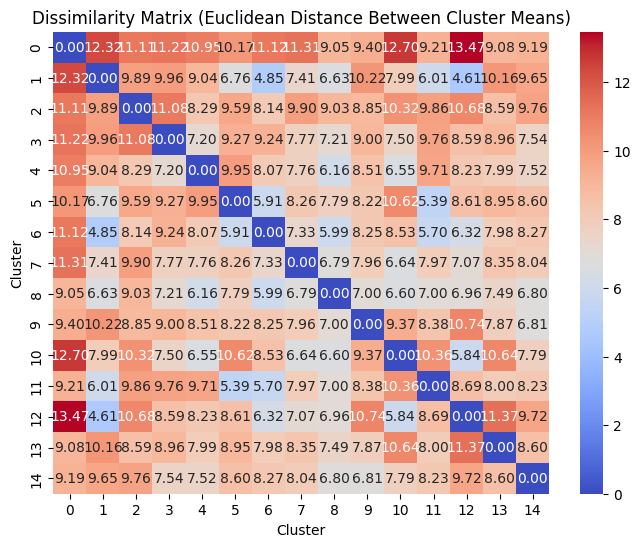

In [125]:
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns


dissimilarity_matrix = euclidean_distances(best_gmm.means_)
plt.figure(figsize=(8, 6))
sns.heatmap(dissimilarity_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Dissimilarity Matrix (Euclidean Distance Between Cluster Means)")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()

In [130]:
src_emb.shape

torch.Size([658, 164])

In [131]:
np.unique(train_data.destinations)

array([    1,     2,     3, ..., 69051, 69052, 69053], shape=(48559,))

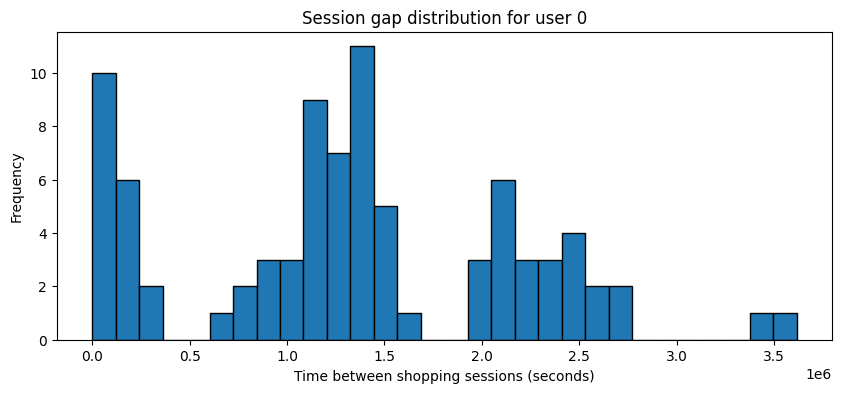

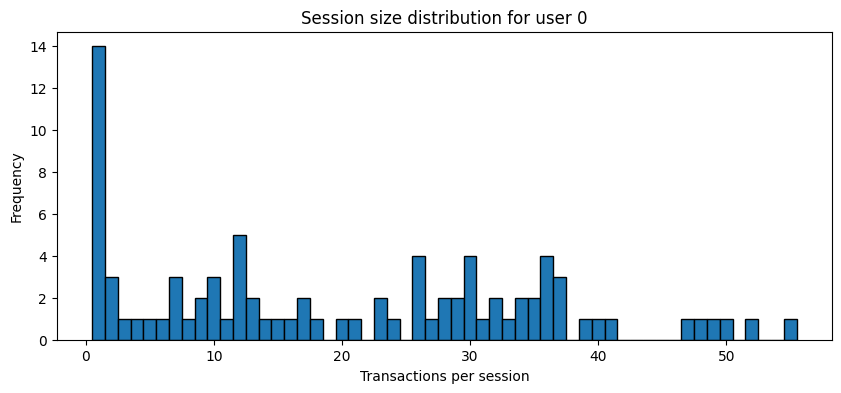

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'source': full_data.sources,
    'timestamp': full_data.timestamps  # Already integer timestamps
})
df = df.sort_values(by=['source', 'timestamp'])

df['time_delta'] = df.groupby('source')['timestamp'].diff()

df['new_session'] = df['time_delta'].fillna(1) > 0

df['session_id'] = df.groupby('source')['new_session'].cumsum()

session_sizes = df.groupby(['source', 'session_id']).size().reset_index(name='transaction_count')

session_starts = df.groupby(['source', 'session_id'])['timestamp'].first().reset_index(name='start_time')

session_info = pd.merge(session_starts, session_sizes, on=['source', 'session_id'])

session_info = session_info.sort_values(['source', 'start_time'])
session_info['session_delta'] = session_info.groupby('source')['start_time'].diff()

user_id = session_info['source'].iloc[0]
user_sessions = session_info[session_info['source'] == user_id]

plt.figure(figsize=(10, 4))
plt.hist(user_sessions['session_delta'].dropna(), bins=30, edgecolor='black')
plt.xlabel('Time between shopping sessions (seconds)')
plt.ylabel('Frequency')
plt.title(f'Session gap distribution for user {user_id}')
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(user_sessions['transaction_count'], bins=range(1, user_sessions['transaction_count'].max()+2), edgecolor='black', align='left')
plt.xlabel('Transactions per session')
plt.ylabel('Frequency')
plt.title(f'Session size distribution for user {user_id}')
plt.show()

In [134]:
indices2 = np.where(labels == 0)[0]
indices3 = np.where(labels == 12)[0]

In [135]:
nodes2 = all_nodes[indices2]
nodes3 = all_nodes[indices3]
nodes3

array([ 2587,  3979, 10469, 12881, 22456, 23949, 27835, 29663, 33224,
       34136, 34280, 34425, 35340, 35608, 35813, 37126, 37789, 38220,
       39783, 40966, 40985, 42972, 43222, 43264, 43433, 44897, 45216,
       45302, 45427, 45696, 46156, 46551, 46679, 46745, 47776, 48699,
       48811, 48826, 48901, 49590, 49669, 50015, 50234, 50283, 50662,
       51327, 52240, 52587, 52877, 53475, 54011, 54093, 54901, 55247,
       55325, 56031, 56772, 56959, 57145, 58368, 58573, 58602, 58730,
       59382, 59884, 59926, 61348, 61862, 61881, 62286, 62314, 62545,
       62984, 64176, 64593, 64632, 65012, 65071, 66047, 66176, 66386,
       67820, 67858])

C:\Users\niclo\AppData\Local\Temp\ipykernel_28956\2635012134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_sessions['session_delta'] = group_sessions.groupby('source')['start_time'].diff()


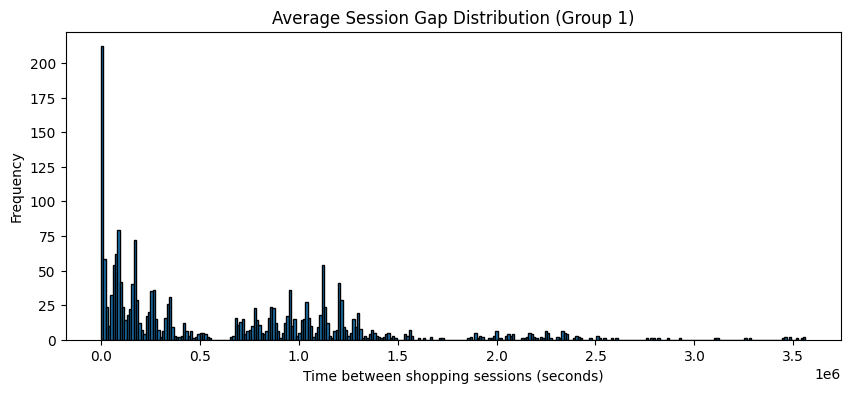

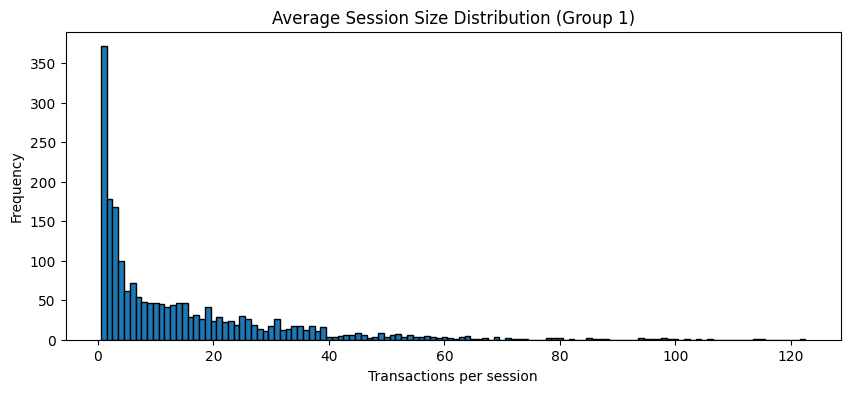

In [136]:
group_sessions = session_info[session_info['source'].isin(nodes2)]

group_sessions['session_delta'] = group_sessions.groupby('source')['start_time'].diff()

all_session_deltas = group_sessions['session_delta'].dropna()
upper_percentile = all_session_deltas.quantile(0.99)
filtered_deltas = all_session_deltas[all_session_deltas <= upper_percentile]
all_session_sizes = group_sessions['transaction_count']

plt.figure(figsize=(10, 4))
plt.hist(filtered_deltas, bins=300, edgecolor='black')
plt.xlabel('Time between shopping sessions (seconds)')
plt.ylabel('Frequency')
plt.title('Average Session Gap Distribution (Group 1)')
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(all_session_sizes, bins=range(1, all_session_sizes.max()+2), edgecolor='black', align='left')
plt.xlabel('Transactions per session')
plt.ylabel('Frequency')
plt.title('Average Session Size Distribution (Group 1)')
plt.show()

C:\Users\niclo\AppData\Local\Temp\ipykernel_28956\2935595011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_sessions_2['session_delta'] = group_sessions_2.groupby('source')['start_time'].diff()


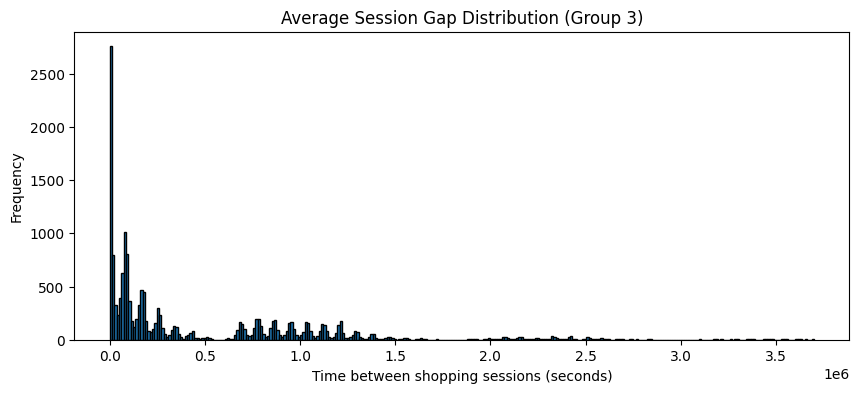

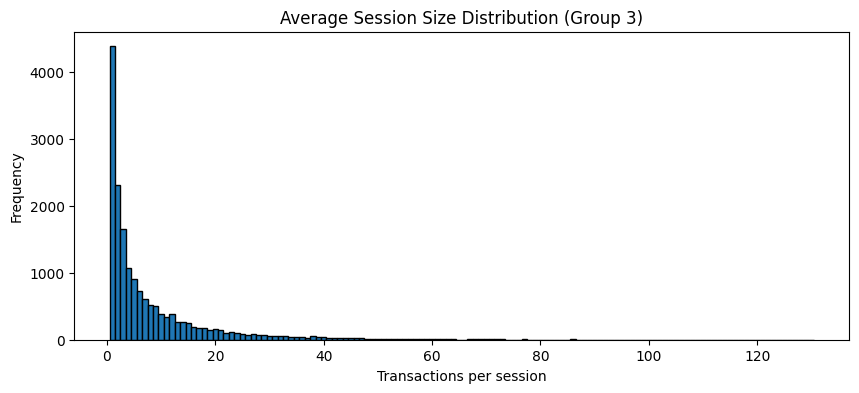

In [137]:
group_sessions_2 = session_info[session_info['source'].isin(nodes3)]

group_sessions_2['session_delta'] = group_sessions_2.groupby('source')['start_time'].diff()

all_session_deltas = group_sessions_2['session_delta'].dropna()
upper_percentile = all_session_deltas.quantile(0.99)
filtered_deltas = all_session_deltas[all_session_deltas <= upper_percentile]
all_session_sizes = group_sessions_2['transaction_count']

plt.figure(figsize=(10, 4))
plt.hist(filtered_deltas, bins=300, edgecolor='black')
plt.xlabel('Time between shopping sessions (seconds)')
plt.ylabel('Frequency')
plt.title('Average Session Gap Distribution (Group 3)')
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(all_session_sizes, bins=range(1, all_session_sizes.max()+2), edgecolor='black', align='left')
plt.xlabel('Transactions per session')
plt.ylabel('Frequency')
plt.title('Average Session Size Distribution (Group 3)')
plt.show()

In [140]:
df = pd.read_csv("data/node_features_with_prod_embedding.csv")
df.head()

C:\Users\niclo\AppData\Local\Temp\ipykernel_28956\2699397690.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/node_features_with_prod_embedding.csv")


,idx,age,marital,income,hh_size,kid_cat,hh_comp,homeowner,node_type,commodity,...,118,119,120,121,122,123,124,125,126,127
0,0,65+,A,35-49K,2.0,None/Unknown,2 Adults No Kids,Homeowner,consumer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,product,CONVENIENT BRKFST/WHLSM SNACKS,...,0.020668,0.191109,-0.196628,0.098720,-0.469710,0.321039,0.373147,0.142749,0.095218,-0.299541
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,product,VEGETABLES SALAD,...,0.026335,0.261862,-0.017810,-0.111792,-0.231166,0.573103,0.247910,0.685991,0.326160,-0.957880
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,product,HAIR CARE PRODUCTS,...,0.198065,0.053747,0.483083,0.009701,-0.203912,-0.498129,0.020669,-0.029661,0.047920,0.039510
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,product,CRACKERS/MISC BKD FD,...,0.174767,0.042445,0.135544,0.226673,-0.114708,0.120713,-0.124915,0.506894,-0.172307,-0.226866


In [141]:
keep_cols = [
    "idx","age","marital","income","hh_size","kid_cat","hh_comp","homeowner",
    "node_type","commodity","department","sub_commodity","size_of_prod",
    "brand","manufacturer","product_id","prod_text","sentence"
]

df = df[keep_cols]

In [142]:
df_consumers = df[df["node_type"] == "consumer"].copy()

df_products = df[df["node_type"] == "product"].copy()

In [143]:
df_consumers.dtypes

idx                int64
age               object
marital           object
income            object
hh_size           object
kid_cat           object
hh_comp           object
homeowner         object
node_type         object
commodity         object
department        object
sub_commodity     object
size_of_prod      object
brand             object
manufacturer     float64
product_id       float64
prod_text         object
sentence          object
dtype: object

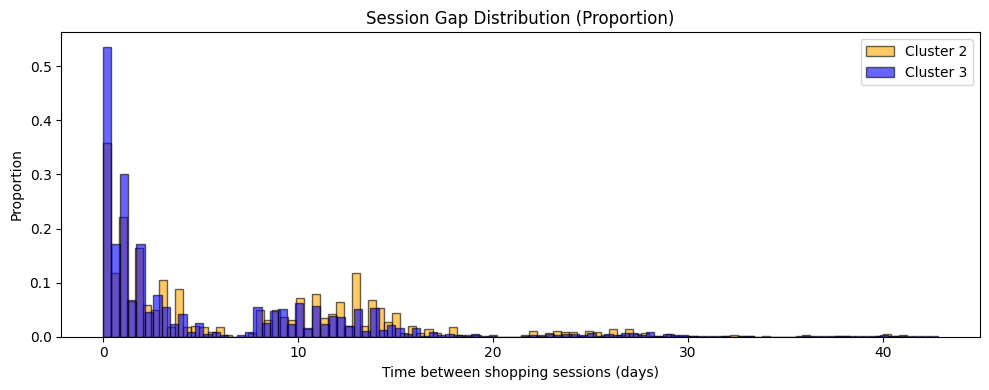

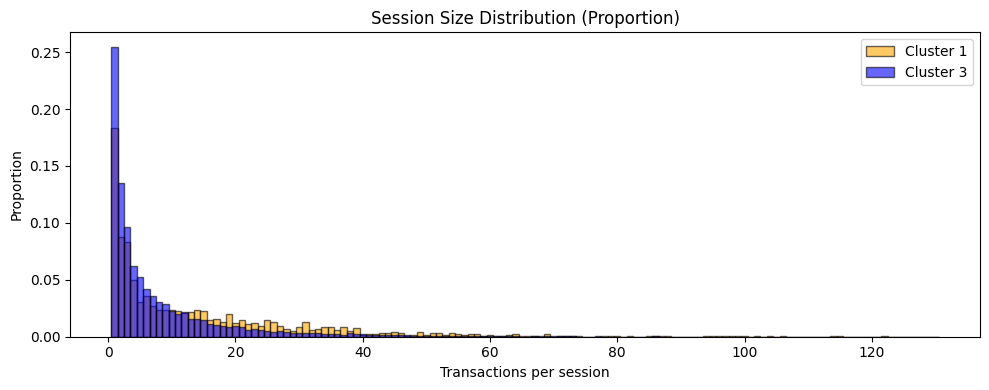

In [138]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_filtered_deltas(df, nodes, upper_quantile=0.99):
    group_sessions = df[df['source'].isin(nodes)].copy()
    group_sessions['session_delta'] = group_sessions.groupby('source')['start_time'].diff()
    
    deltas = group_sessions['session_delta'].dropna() / (24*3600)
    upper_percentile = deltas.quantile(upper_quantile)
    filtered = deltas[deltas <= upper_percentile]
    return filtered

def get_session_sizes(df, nodes):
    group_sessions = df[df['source'].isin(nodes)]
    return group_sessions['transaction_count']

deltas2 = get_filtered_deltas(session_info, nodes2)
deltas3 = get_filtered_deltas(session_info, nodes3)

sizes2 = get_session_sizes(session_info, nodes2)
sizes3 = get_session_sizes(session_info, nodes3)

plt.figure(figsize=(10,4))
plt.hist(deltas2, bins=100, density=True, alpha=0.6, color='orange', label='Cluster 2', edgecolor='black')
plt.hist(deltas3, bins=100, density=True, alpha=0.6, color='blue', label='Cluster 3', edgecolor='black')
plt.xlabel('Time between shopping sessions (days)')
plt.ylabel('Proportion')
plt.title('Session Gap Distribution (Proportion)')
plt.legend()
plt.tight_layout()
plt.show()

max_transactions = max(sizes2.max(), sizes3.max())
bins = np.arange(1, max_transactions+2) - 0.5

plt.figure(figsize=(10,4))
plt.hist(sizes2, bins=bins, density=True, alpha=0.6, color='orange', label='Cluster 1', edgecolor='black', align='mid')
plt.hist(sizes3, bins=bins, density=True, alpha=0.6, color='blue', label='Cluster 3', edgecolor='black', align='mid')
plt.xlabel('Transactions per session')
plt.ylabel('Proportion')
plt.title('Session Size Distribution (Proportion)')
plt.legend()
plt.tight_layout()
plt.show()


In [144]:
consumer_stats = df_consumers.describe(include="all")
product_stats  = df_products.describe(include="all")

In [145]:
consumer_stats

,idx,age,marital,income,hh_size,kid_cat,hh_comp,homeowner,node_type,commodity,department,sub_commodity,size_of_prod,brand,manufacturer,product_id,prod_text,sentence
count,801.000000,801,801,801,801,801,801,801,801,0,0,0,0,0,0.0,0.0,0,0
unique,NaN,6,3,12,9,4,6,5,1,0,0,0,0,0,NaN,NaN,0,0
top,NaN,45-54,U,50-74K,2,None/Unknown,2 Adults No Kids,Homeowner,consumer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,288,344,192,287,558,255,504,801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,47640.669164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,15683.062308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,38220.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,51327.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,60496.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
consumer_cat_cols = [
    "age", "marital", "hh_size", "kid_cat",
    "hh_comp", "homeowner"
]

prod_cat_cols = [
    "commodity", "department",
    "sub_commodity", "size_of_prod", "brand",
    "manufacturer" 
]

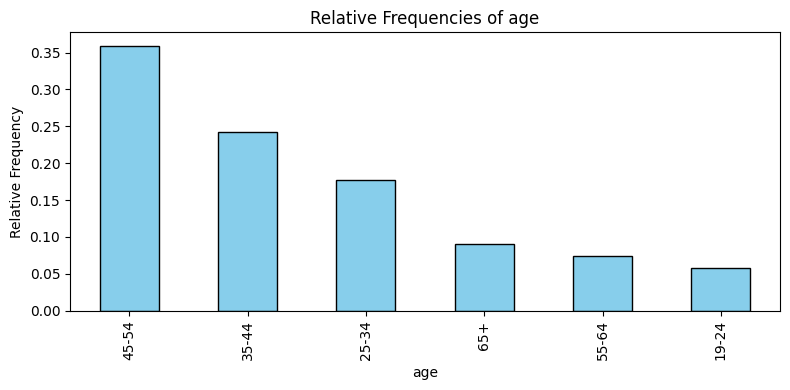

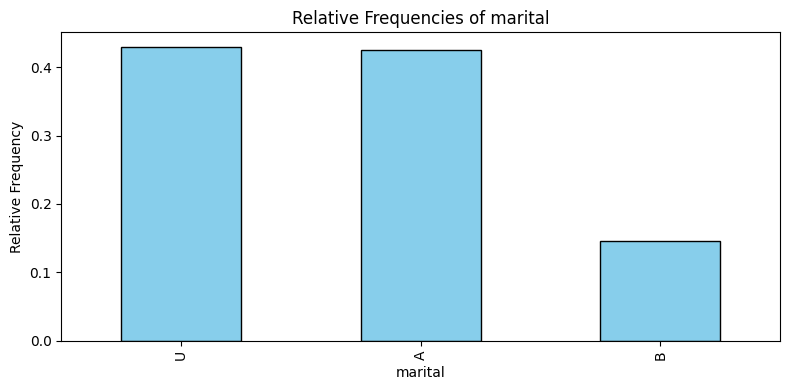

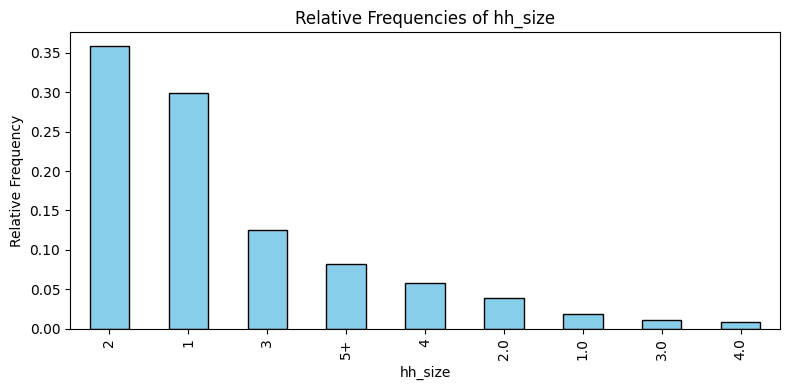

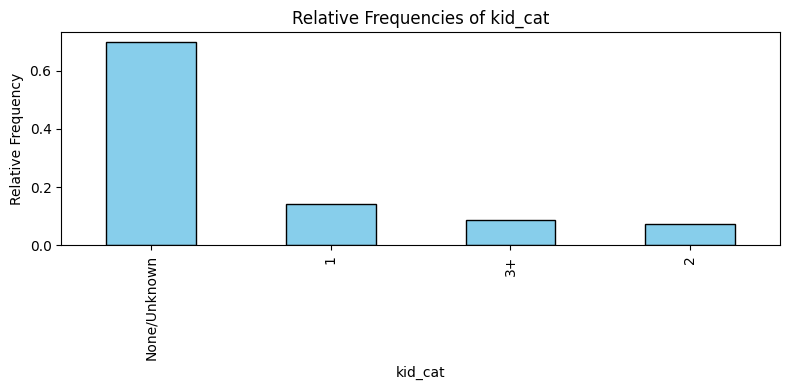

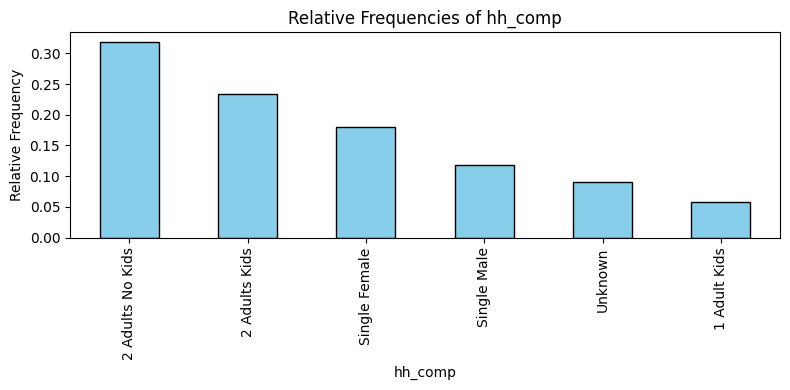

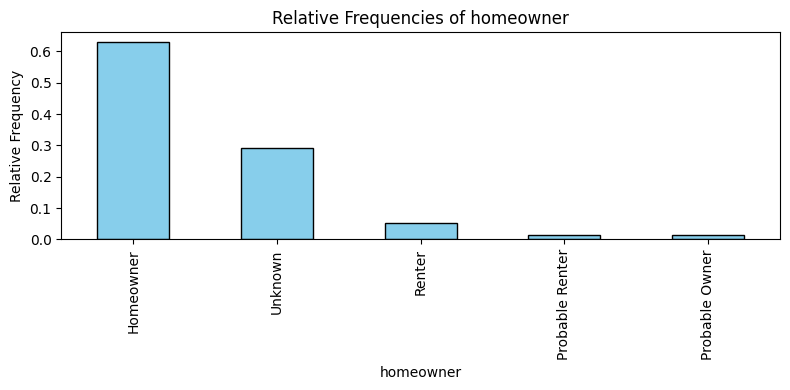

In [147]:
import matplotlib.pyplot as plt

for col in consumer_cat_cols:
    plt.figure(figsize=(8,4))
    df_consumers[col].value_counts(normalize=True).plot(
        kind="bar",
        color="skyblue",
        edgecolor="black"
    )
    plt.title(f"Relative Frequencies of {col}")
    plt.xlabel(col)
    plt.ylabel("Relative Frequency")
    plt.tight_layout()
    plt.show()

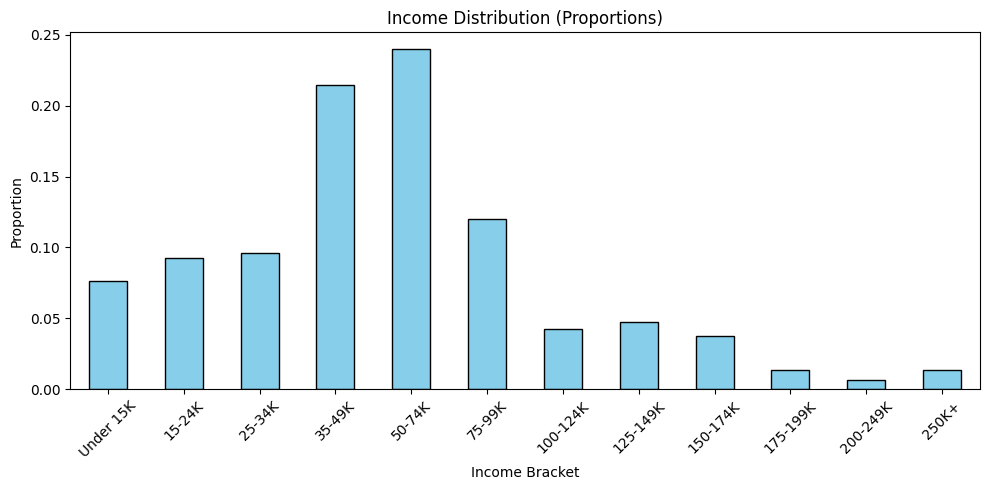

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

ordered_labels = [
    "Under 15K", "15-24K", "25-34K", "35-49K", "50-74K",
    "75-99K", "100-124K", "125-149K", "150-174K", 
    "175-199K", "200-249K", "250K+"
]

df_clean = df.dropna(subset=["income"]).copy()
df_clean["income_bracket"] = pd.Categorical(df_clean["income"], 
                                            categories=ordered_labels, 
                                            ordered=True)

income_prop = df_clean["income_bracket"].value_counts(normalize=True).sort_index()

plt.figure(figsize=(10,5))
income_prop.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Income Bracket")
plt.ylabel("Proportion")
plt.title("Income Distribution (Proportions)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [149]:
nodes2_df = df_consumers[df_consumers["idx"].isin(nodes2)].copy()
nodes3_df = df_consumers[df_consumers["idx"].isin(nodes3)].copy()

In [150]:
cat_cols = ["marital", "kid_cat", "hh_comp", "homeowner"]
num_cols = ["age", "hh_size"]

cat_summary2 = {col: nodes2_df[col].value_counts(normalize=True) for col in cat_cols}
cat_summary3 = {col: nodes3_df[col].value_counts(normalize=True) for col in cat_cols}

num_summary2 = nodes2_df[num_cols].describe()
num_summary3 = nodes3_df[num_cols].describe()

In [151]:
num_summary2

,age,hh_size
count,12,12
unique,5,6
top,25-34,2
freq,6,4


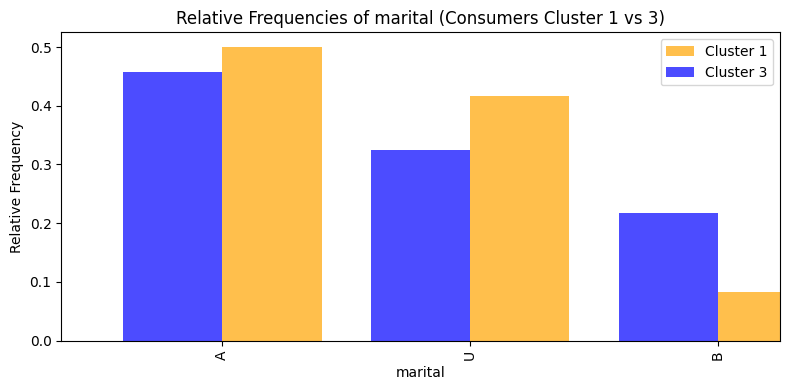

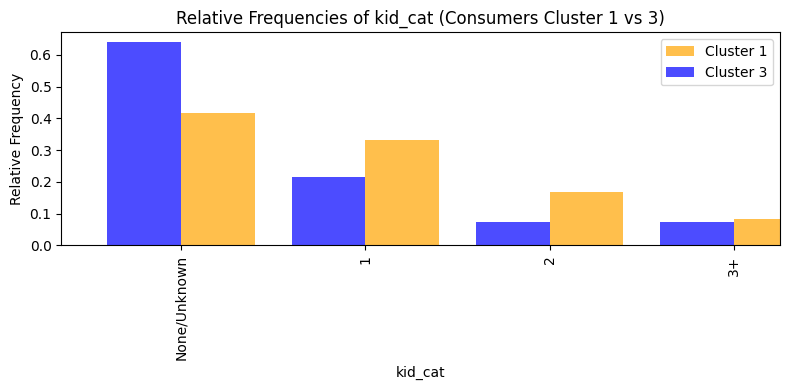

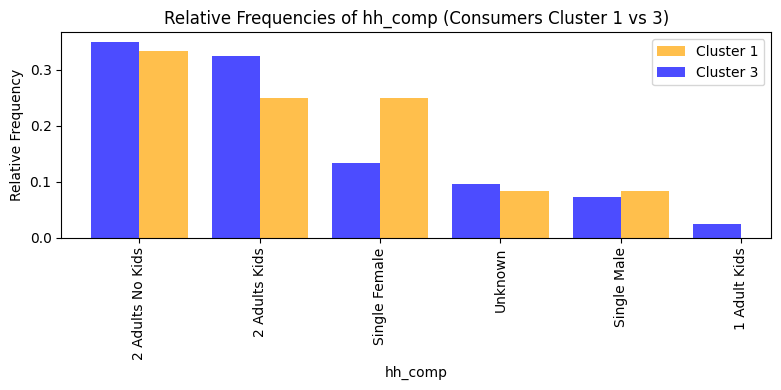

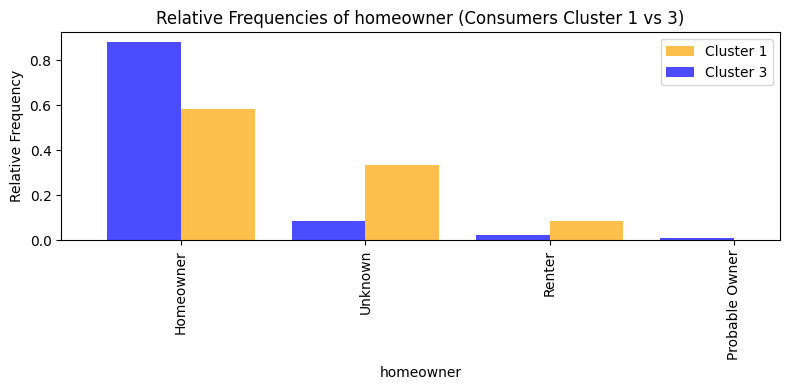

In [152]:
import matplotlib.pyplot as plt

for col in cat_cols:
    plt.figure(figsize=(8,4))
    nodes2_df[col].value_counts(normalize=True).plot(
        kind="bar", alpha=0.7, color="orange", width=0.4, position=0, label="Cluster 1"
    )
    nodes3_df[col].value_counts(normalize=True).plot(
        kind="bar", alpha=0.7, color="blue", width=0.4, position=1, label="Cluster 3"
    )
    plt.title(f"Relative Frequencies of {col} (Consumers Cluster 1 vs 3)")
    plt.xlabel(col)
    plt.ylabel("Relative Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

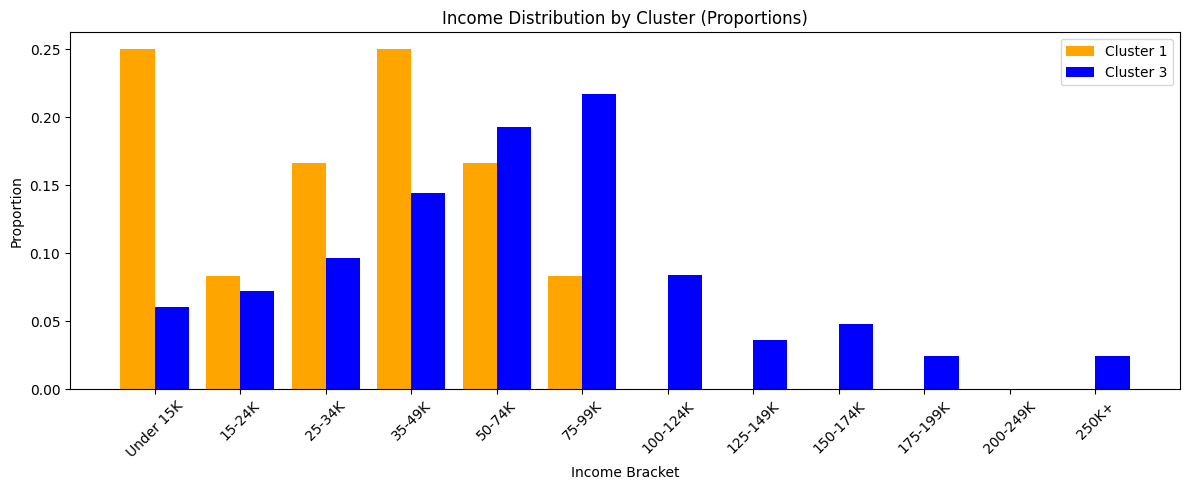

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def assign_brackets(df, labels=ordered_labels):
    df_clean = df.dropna(subset=["income"]).copy()
    df_clean["income_bracket"] = pd.Categorical(df_clean["income"], categories=labels, ordered=True)
    return df_clean

nodes2_df_bracket = assign_brackets(nodes2_df)
nodes3_df_bracket = assign_brackets(nodes3_df)

prop2 = nodes2_df_bracket["income_bracket"].value_counts(normalize=True).sort_index()
prop3 = nodes3_df_bracket["income_bracket"].value_counts(normalize=True).sort_index()

x = np.arange(len(ordered_labels))
width = 0.4

plt.figure(figsize=(12,5))
plt.bar(x - width/2, prop2.values, width=width, color="orange", label="Cluster 1")
plt.bar(x + width/2, prop3.values, width=width, color="blue", label="Cluster 3")

plt.xticks(x, ordered_labels, rotation=45)
plt.xlabel("Income Bracket")
plt.ylabel("Proportion")
plt.title("Income Distribution by Cluster (Proportions)")
plt.legend()
plt.tight_layout()
plt.show()


In [154]:
print(df["age"].unique())
print(nodes3_df["age"].unique())

['65+' nan '45-54' '25-34' '35-44' '19-24' '55-64']
['25-34' '45-54' '35-44' '19-24' '65+' '55-64']


In [155]:
age_ordered_labels = ['19-24', '25-34', '35-44', '45-54', '55-64', '65+']

nodes2_df['age_bracket'] = pd.Categorical(nodes2_df['age'], categories=age_ordered_labels, ordered=True)
nodes3_df['age_bracket'] = pd.Categorical(nodes3_df['age'], categories=age_ordered_labels, ordered=True)

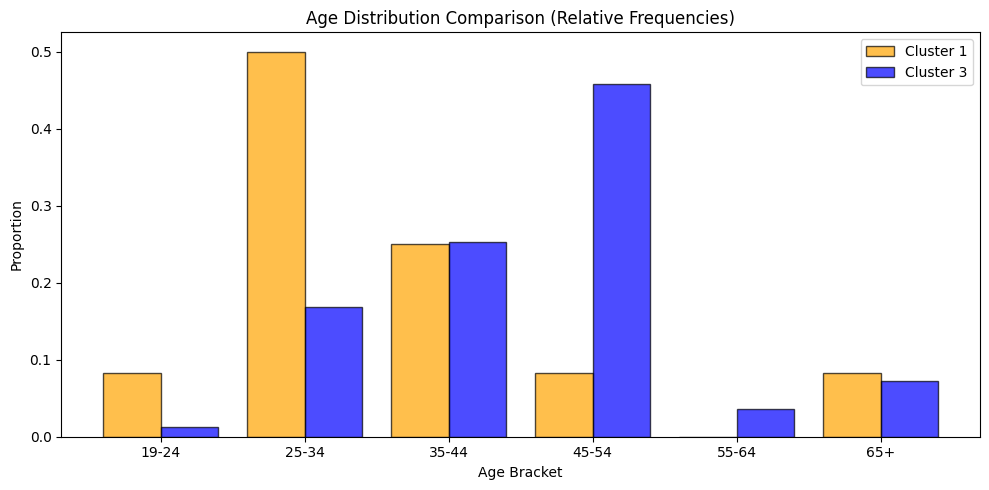

In [156]:
freq2 = nodes2_df['age_bracket'].value_counts(normalize=True).sort_index()

freq3 = nodes3_df['age_bracket'].value_counts(normalize=True).sort_index()
import numpy as np

x = np.arange(len(age_ordered_labels))
width = 0.4

plt.figure(figsize=(10,5))
plt.bar(x - width/2, freq2.values, width=width, color='orange', alpha=0.7, label='Cluster 1', edgecolor='black')
plt.bar(x + width/2, freq3.values, width=width, color='blue', alpha=0.7, label='Cluster 3', edgecolor='black')

plt.xticks(x, age_ordered_labels)
plt.xlabel('Age Bracket')
plt.ylabel('Proportion')
plt.title('Age Distribution Comparison (Relative Frequencies)')
plt.legend()
plt.tight_layout()
plt.show()


In [157]:
print(df["hh_size"].unique())
print(nodes3_df["age"].unique())

[2.0 nan 3.0 4.0 1.0 '1' '5+' '2' '4' '3']
['25-34' '45-54' '35-44' '19-24' '65+' '55-64']


In [158]:
def clean_hh_size(x):
    if pd.isna(x):
        return np.nan
    if x == '5+':
        return 5
    try:
        return int(x)
    except:
        return np.nan

nodes2_df['hh_size_clean'] = nodes2_df['hh_size'].apply(clean_hh_size)
nodes3_df['hh_size_clean'] = nodes3_df['hh_size'].apply(clean_hh_size)


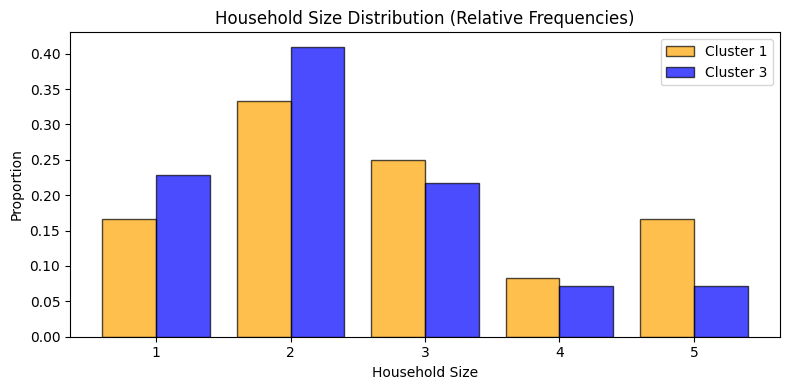

In [159]:
hh_ordered_labels = [1, 2, 3, 4, 5]
nodes2_df['hh_size_cat'] = pd.Categorical(nodes2_df['hh_size_clean'],
                                          categories=hh_ordered_labels,
                                          ordered=True)

nodes3_df['hh_size_cat'] = pd.Categorical(nodes3_df['hh_size_clean'],
                                          categories=hh_ordered_labels,
                                          ordered=True)

freq2 = nodes2_df['hh_size_cat'].value_counts(normalize=True).sort_index()
freq3 = nodes3_df['hh_size_cat'].value_counts(normalize=True).sort_index()

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(freq2))
width = 0.4

plt.figure(figsize=(8,4))
plt.bar(x - width/2, freq2.values, width=width, color='orange', alpha=0.7, label='Cluster 1', edgecolor='black')
plt.bar(x + width/2, freq3.values, width=width, color='blue', alpha=0.7, label='Cluster 3', edgecolor='black')

plt.xticks(x, freq2.index)
plt.xlabel('Household Size')
plt.ylabel('Proportion')
plt.title('Household Size Distribution (Relative Frequencies)')
plt.legend()
plt.tight_layout()
plt.show()


In [160]:
transactions = pd.read_csv("data/edges_idxed.csv")
transactions.head()

,idx,ts,qty,sales_value,src,dst
0,0,14832240,1,4.69,0,1
1,1,122052660,1,0.99,0,2
2,2,122052660,1,6.49,0,3
3,3,122052660,1,3.49,0,4
4,4,122052660,1,1.99,0,5


In [161]:
overall_stats = transactions[["qty", "sales_value"]].describe()
print("Overall Summary Statistics:")
print(overall_stats)

Overall Summary Statistics:
                qty   sales_value
count  1.427303e+06  1.427303e+06
mean   1.148580e+02  3.151199e+00
std    1.252137e+03  4.251720e+00
min    0.000000e+00  0.000000e+00
25%    1.000000e+00  1.290000e+00
50%    1.000000e+00  2.090000e+00
75%    1.000000e+00  3.490000e+00
max    8.963800e+04  8.400000e+02


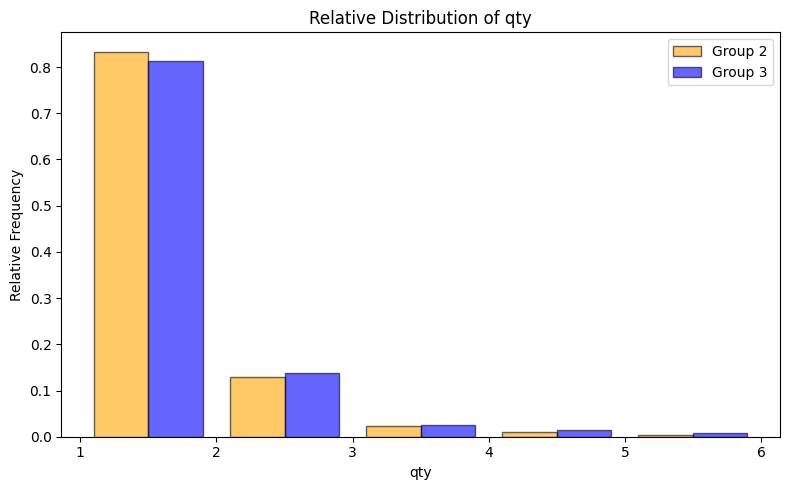

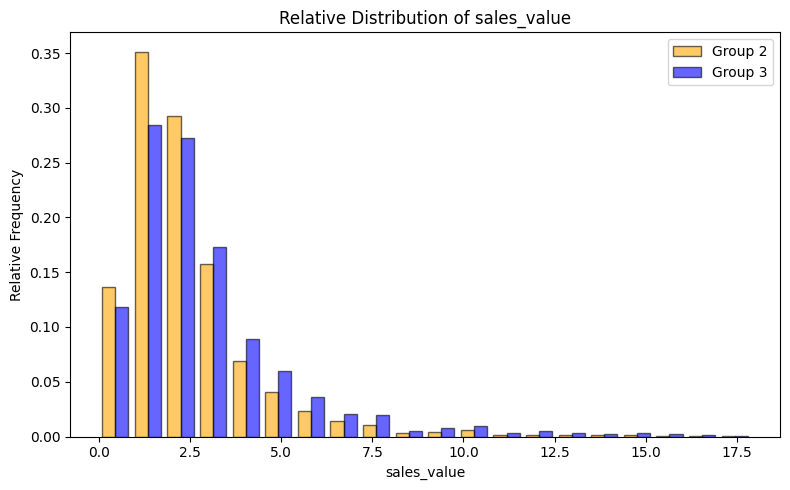

In [162]:
group2 = transactions[transactions["src"].isin(nodes2)]
group3 = transactions[transactions["src"].isin(nodes3)]

def plot_relative_distribution(group2, group3, col, group_labels=("Group 2","Group 3"), bins=20, clip_quantile=0.99):
    data1 = group2[col].dropna()
    data2 = group3[col].dropna()
    data1 = data1[data1 > 0]
    data2 = data2[data2 > 0]

    q1 = data1.quantile(clip_quantile)
    q2 = data2.quantile(clip_quantile)
    cutoff = min(q1, q2)

    data1 = data1[data1 <= cutoff]
    data2 = data2[data2 <= cutoff]

    bin_edges = np.linspace(min(data1.min(), data2.min()), max(data1.max(), data2.max()), bins + 1)

    counts1, _ = np.histogram(data1, bins=bin_edges, density=True)
    counts2, _ = np.histogram(data2, bins=bin_edges, density=True)

    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (centers[1] - centers[0]) * 0.4

    plt.figure(figsize=(8,5))
    plt.bar(centers - width/2, counts1, width=width, alpha=0.6, color="orange", label=group_labels[0], edgecolor="black")
    plt.bar(centers + width/2, counts2, width=width, alpha=0.6, color="blue", label=group_labels[1], edgecolor="black")

    plt.xlabel(col)
    plt.ylabel("Relative Frequency")
    plt.title(f"Relative Distribution of {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_relative_distribution(group2, group3, col="qty", bins=5, clip_quantile=0.99)

plot_relative_distribution(group2, group3, col="sales_value", bins=20, clip_quantile=0.99)

Next we move onto the experiments to test cluster robustness through time

In [163]:
min_train_time = 0
all_nodes = np.array(sorted(np.unique(train_data.sources)))

dest_nodes = all_nodes.copy()
neg_nodes = all_nodes.copy()
dummy_edge_idxs = np.zeros_like(all_nodes, dtype=np.int32)
times_new = np.full_like(all_nodes, fill_value=min_train_time, dtype=np.float32)

with torch.no_grad():
    src_emb_2, _, _ = tgn.compute_temporal_embeddings(
        source_nodes=all_nodes,
        destination_nodes=dest_nodes,
        negative_nodes=neg_nodes,
        edge_times=times_new,
        edge_idxs=dummy_edge_idxs,
        n_neighbors=10
    )

In [164]:
src_emb_2[:30]

tensor([[ 0.0406, -0.0492,  0.1729,  ..., -0.0727, -0.1848, -0.1003],
        [-0.0734, -0.1757,  0.2388,  ..., -0.1943, -0.1437, -0.0390],
        [-0.0931, -0.2674,  0.2573,  ..., -0.0261, -0.2735,  0.0344],
        ...,
        [ 0.1913, -0.1534,  0.2762,  ...,  0.0965, -0.1612, -0.1181],
        [ 0.0147, -0.1845,  0.2825,  ..., -0.1025, -0.3458,  0.0019],
        [-0.0858, -0.1461,  0.1931,  ..., -0.1291, -0.2238, -0.1589]])

In [174]:
import numpy as np

min_time = train_data.timestamps.min()
max_time = train_data.timestamps.max()
mid_time = min_time + (max_time - min_time) / 2

n_checks = 100
time_steps = np.linspace(mid_time, max_time, n_checks)

In [175]:
all_nodes = np.array(sorted(np.unique(train_data.sources)))
dest_nodes = all_nodes.copy()
neg_nodes = all_nodes.copy()
dummy_edge_idxs = np.zeros_like(all_nodes, dtype=np.int32)

embeddings_over_time = {}

import torch

for t in time_steps:
    times_new = np.full_like(all_nodes, fill_value=t, dtype=np.float32)
    with torch.no_grad():
        src_emb, _, _ = tgn.compute_temporal_embeddings(
            source_nodes=all_nodes,
            destination_nodes=dest_nodes,
            negative_nodes=neg_nodes,
            edge_times=times_new,
            edge_idxs=dummy_edge_idxs,
            n_neighbors=10
        )
    embeddings_over_time[t] = src_emb.cpu().numpy()


In [167]:
from sklearn.cluster import KMeans

emb_t0 = embeddings_over_time[time_steps[0]]
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(emb_t0)
labels_t0 = kmeans.labels_


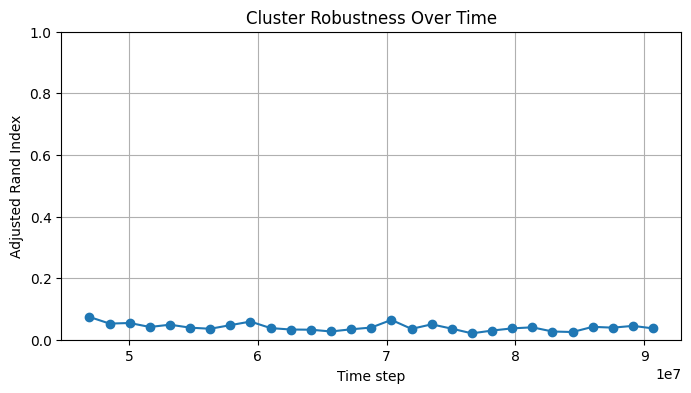

In [168]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

cluster_stability = {}

for t in time_steps[1:]:
    emb_t = embeddings_over_time[t]

    distances = cdist(emb_t, kmeans.cluster_centers_)
    labels_t = distances.argmin(axis=1)

    ari = adjusted_rand_score(labels_t0, labels_t)
    cluster_stability[t] = ari

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(list(cluster_stability.keys()), list(cluster_stability.values()), marker='o')
plt.xlabel("Time step")
plt.ylabel("Adjusted Rand Index")
plt.title("Cluster Robustness Over Time")
plt.ylim(0,1)
plt.grid(True)
plt.show()


In [169]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(embeddings_over_time[t], labels_t0) for t in time_steps]


In [170]:
silhouette_scores


[0.000381465011741966,
 -0.035228483378887177,
 -0.03693704307079315,
 -0.031227175146341324,
 -0.03397071734070778,
 -0.03471558541059494,
 -0.030748065561056137,
 -0.03152953088283539,
 -0.033204153180122375,
 -0.03770419582724571,
 -0.030100688338279724,
 -0.027923548594117165,
 -0.029711592942476273,
 -0.026957111433148384,
 -0.02887343242764473,
 -0.03197823092341423,
 -0.03568466752767563,
 -0.027843695133924484,
 -0.026851825416088104,
 -0.03173695504665375,
 -0.030674492940306664,
 -0.030973857268691063,
 -0.030565841123461723,
 -0.029897570610046387,
 -0.030719365924596786,
 -0.033068910241127014,
 -0.03261542320251465,
 -0.03639795631170273,
 -0.03043164312839508,
 -0.04224466532468796]

In [171]:
stability_per_cluster = {}
for cluster_id in range(n_clusters):
    nodes_in_cluster = np.where(labels_t0 == cluster_id)[0]
    stability = []
    for t in time_steps[1:]:
        emb_t = embeddings_over_time[t]
        from scipy.spatial.distance import cdist
        distances = cdist(emb_t[nodes_in_cluster], kmeans.cluster_centers_)
        labels_t = distances.argmin(axis=1)
        stability.append(np.mean(labels_t == cluster_id))
    stability_per_cluster[cluster_id] = np.mean(stability)


In [172]:
stability_per_cluster

{0: np.float64(0.007662835249042145),
 1: np.float64(0.34754990925589835),
 2: np.float64(0.12807881773399016),
 3: np.float64(0.29467084639498436),
 4: np.float64(0.021551724137931036),
 5: np.float64(0.19770114942528735),
 6: np.float64(0.038980509745127435),
 7: np.float64(0.1977878985035784),
 8: np.float64(0.1343390804597701),
 9: np.float64(0.16041979010494753),
 10: np.float64(0.06896551724137932),
 11: np.float64(0.28546486250545605),
 12: np.float64(0.03965517241379311),
 13: np.float64(0.09512485136741974),
 14: np.float64(0.022988505747126436)}

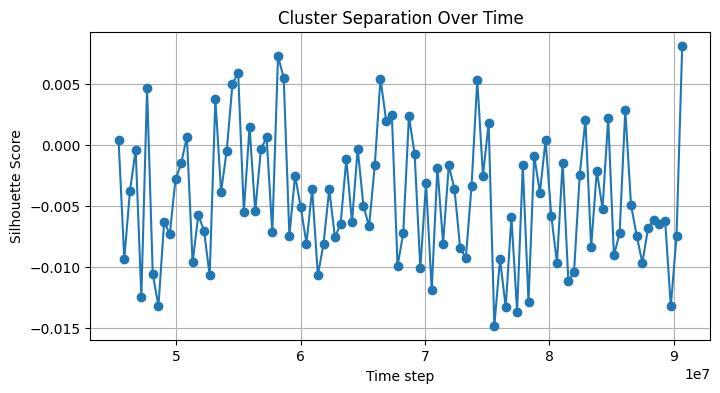

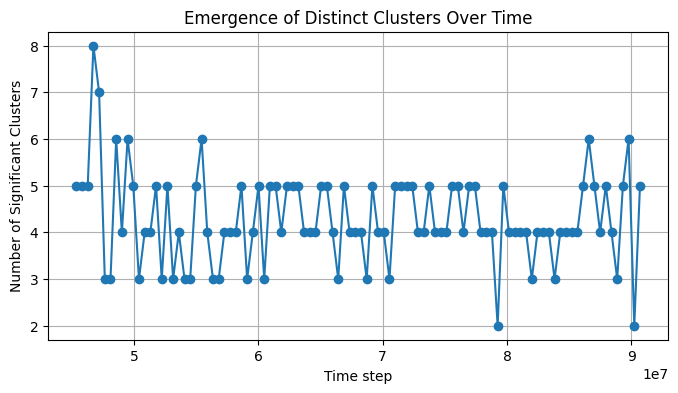

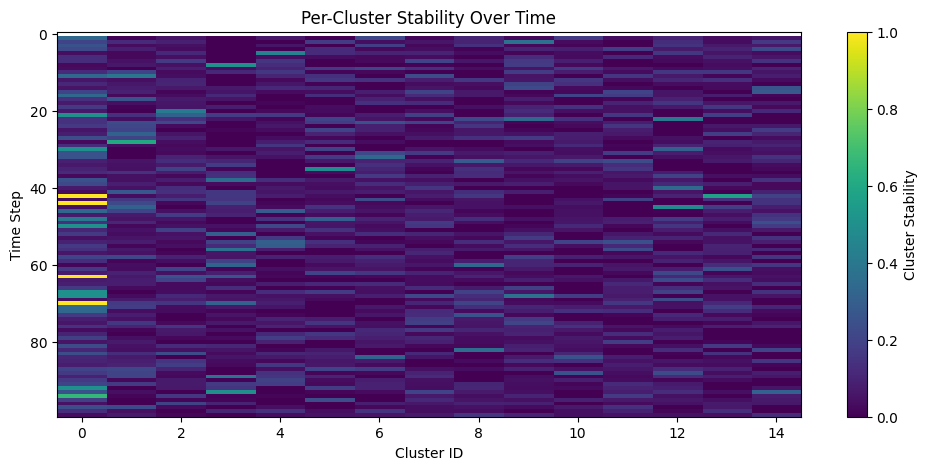

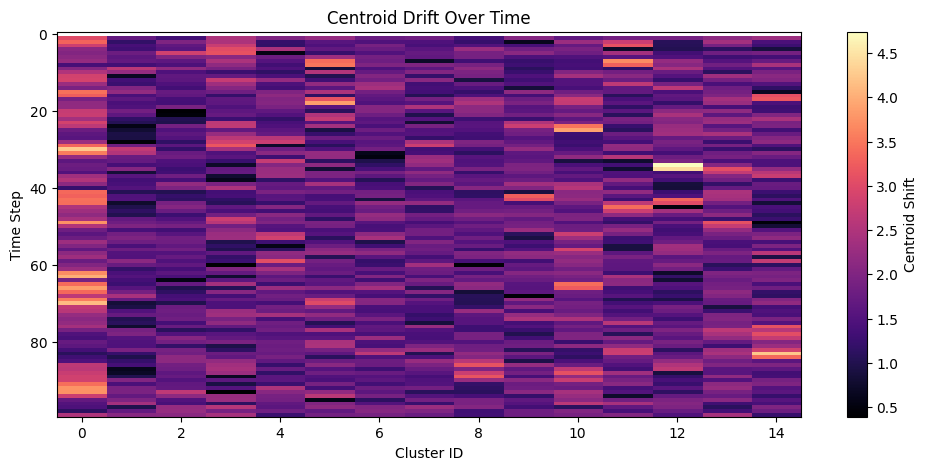

In [178]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

n_clusters = 15
min_cluster_fraction = 0.05  # minimum fraction of nodes to consider cluster significant
previous_labels = None
previous_centroids = None

cluster_stability_over_time = {}
silhouette_over_time = {}
centroid_distances_over_time = {}
significant_clusters_over_time = {}

for t in sorted(embeddings_over_time.keys()):
    emb = embeddings_over_time[t]
    
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(emb)
    
    centroids = np.array([emb[labels == i].mean(axis=0) if np.any(labels==i) else np.zeros(emb.shape[1])
                          for i in range(n_clusters)])
    
    try:
        sil_score = silhouette_score(emb, labels)
    except:
        sil_score = np.nan
    silhouette_over_time[t] = sil_score
    
    stability_scores = {}
    if previous_labels is not None:
        for c in range(n_clusters):
            nodes_in_c_prev = np.where(previous_labels == c)[0]
            if len(nodes_in_c_prev) == 0:
                stability_scores[c] = 0.0
                continue
            current_assignments = labels[nodes_in_c_prev]
            proportion_retained = np.mean(current_assignments == c)
            stability_scores[c] = proportion_retained
    else:
        stability_scores = {c: np.nan for c in range(n_clusters)}
    
    cluster_stability_over_time[t] = stability_scores
    
    if previous_centroids is not None:
        centroid_shift = np.linalg.norm(centroids - previous_centroids, axis=1)
        centroid_distances_over_time[t] = centroid_shift
    else:
        centroid_distances_over_time[t] = np.full(n_clusters, np.nan)
    
    counts = np.array([np.sum(labels == c) for c in range(n_clusters)])
    significant_clusters = np.sum(counts / counts.sum() >= min_cluster_fraction)
    significant_clusters_over_time[t] = significant_clusters
    
    previous_labels = labels.copy()
    previous_centroids = centroids.copy()


time_list = sorted(embeddings_over_time.keys())

plt.figure(figsize=(8,4))
plt.plot(time_list, [silhouette_over_time[t] for t in time_list], marker='o')
plt.xlabel("Time step")
plt.ylabel("Silhouette Score")
plt.title("Cluster Separation Over Time")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(time_list, [significant_clusters_over_time[t] for t in time_list], marker='o')
plt.xlabel("Time step")
plt.ylabel("Number of Significant Clusters")
plt.title("Emergence of Distinct Clusters Over Time")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
stability_matrix = np.array([[cluster_stability_over_time[t].get(c, np.nan) for c in range(n_clusters)]
                             for t in time_list])
plt.imshow(stability_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar(label='Cluster Stability')
plt.xlabel("Cluster ID")
plt.ylabel("Time Step")
plt.title("Per-Cluster Stability Over Time")
plt.show()

plt.figure(figsize=(12,5))
centroid_matrix = np.array([centroid_distances_over_time[t] for t in time_list])
plt.imshow(centroid_matrix, aspect='auto', cmap='magma', interpolation='none')
plt.colorbar(label='Centroid Shift')
plt.xlabel("Cluster ID")
plt.ylabel("Time Step")
plt.title("Centroid Drift Over Time")
plt.show()
